Som
https://notebook.community/tcstewar/testing_notebooks/som/Self%20Organizing%20Map

### save as requirements.txt and run pip install -r requirements.txt

matplotlib
numpy
nengo
pandas
tensorflow == 1.15.0
pathlib
logging
sklearn
scipy

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import pandas as pd

In [2]:
data = np.random.uniform(0,1, (100,3))
# data = pd.read_excel("CM1.xlsx", engine="openpyxl")
# data.drop(data.columns[len(data.columns) - 1], axis=1, inplace=True)

In [3]:
class SelfOrganizingMap(nengo.Process):
    def __init__(self, weights, learning_rate=1e1, influence_sigma=1.5):
        self.weights = weights
        self.learning_rate = learning_rate
        self.influence_sigma = influence_sigma

        super().__init__(default_size_in=weights.shape[2],
                         default_size_out=weights.shape[0]*weights.shape[1])
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        # this called during the build process, so any computationally expensive
        #  pre-processing should be done here.  There isn't really much for an SOM,
        #  but we can pre-generate the distance matrix to speed that part up

        pos = np.array(np.meshgrid(np.arange(self.weights.shape[1]),
                                   np.arange(self.weights.shape[0])))

        def step_som(t, x, w=self.weights, pos=pos,
                     sigma=self.influence_sigma,
                     learning_rate=self.learning_rate):
            # this will be called every timestep, with x as the current input

            # first, find the closest element in the map
            diff = np.sum((w - x[None,None,:])**2, axis=2)
            best = np.argmin(diff)
            best = np.array([best % diff.shape[1], best // diff.shape[1]])
            #assert diff[best[1],best[0]] == np.min(diff)

            # now compute how much to influence the elements
            dist = np.sum((pos - best[:,None,None])**2, axis=0)
            influence = np.exp(-dist/(2*sigma**2))

            # update the weights
            w += learning_rate * dt * influence[:,:,None] * (x - w)

            # the output from the map every timestep will just be the influence
            return influence.flatten()

        return step_som

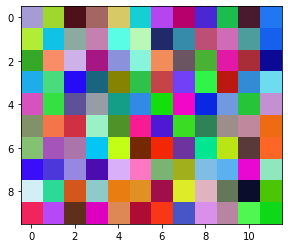

In [4]:
w = np.random.uniform(0, 1, (10, 12, 3))
plt.imshow(w)

In [5]:
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.PresentInput(data, presentation_time=0.001))

    som = nengo.Node(SelfOrganizingMap(w))
    nengo.Connection(stim, som, synapse=None)
    p = nengo.Probe(som)

sim = nengo.Simulator(model)
sim.run(10)

C:\Users\wwcha\Anaconda3\lib\site-packages\nengo\cache.py:613: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

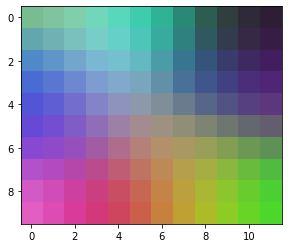

In [6]:
plt.imshow(w)

https://github.com/cgorman/tensorflow-som/blob/master/tf_som.py

In [7]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import logging

In [8]:
class SelfOrganizingMap:
    """
    2-D rectangular grid planar Self-Organizing Map with Gaussian neighbourhood function
    """

    def __init__(self, m, n, dim, max_epochs=100, initial_radius=None, batch_size=128, initial_learning_rate=0.1,
                 graph=None, std_coeff=0.5, model_name='Self-Organizing-Map', softmax_activity=False, gpus=0,
                 output_sensitivity=-1.0, input_tensor=None, session=None, checkpoint_dir=None, restore_path=None):
        """
        Initialize a self-organizing map on the tensorflow graph
        :param m: Number of rows of neurons
        :param n: Number of columns of neurons
        :param dim: Dimensionality of the input data
        :param max_epochs: Number of epochs to train for
        :param initial_radius: Starting value of the neighborhood radius - defaults to max(m, n) / 2.0
        :param batch_size: Number of input vectors to train on at a time
        :param initial_learning_rate: The starting learning rate of the SOM. Decreases linearly w/r/t `max_epochs`
        :param graph: The tensorflow graph to build the network on
        :param std_coeff: Coefficient of the standard deviation of the neighborhood function
        :param model_name: The name that will be given to the checkpoint files
        :param softmax_activity: If `True` the activity will be softmaxed to form a probability distribution
        :param gpus: The number of GPUs to train the SOM on
        :param output_sensitivity The constant controlling the width of the activity gaussian. Numbers further from zero
                elicit activity when distance is low, effectively introducing a threshold on the distance w/r/t activity.
                See the plot in the readme file for a little introduction.
        :param session: A `tf.Session()` for executing the graph
        """
        self._m = abs(int(m))
        self._n = abs(int(n))
        self._dim = abs(int(dim))
        if initial_radius is None:
            self._initial_radius = max(m, n) / 2.0
        else:
            self._initial_radius = float(initial_radius)
        self._max_epochs = abs(int(max_epochs))
        self._batch_size = abs(int(batch_size))
        self._std_coeff = abs(float(std_coeff))
        self._softmax_activity = bool(softmax_activity)
        self._model_name = str(model_name)
        if output_sensitivity > 0:
            output_sensitivity *= -1
        elif output_sensitivity == 0:
            output_sensitivity = -1
        # The activity equation is kind of long so I'm naming this c for brevity
        self._c = float(output_sensitivity)
        self._sess = session
        self._checkpoint_dir = checkpoint_dir
        self._restore_path = restore_path
        self._gpus = int(abs(gpus))
        self._trained = False

        # Initialized later, just declaring up here for neatness and to avoid warnings
        self._weights = None
        self._location_vects = None
        self._input = None
        self._epoch = None
        self._training_op = None
        self._centroid_grid = None
        self._locations = None
        self._activity_op = None
        self._saver = None
        self._merged = None
        self._activity_merged = None
        # This will be the collection of summaries for this subgraph. Add new summaries to it and pass it to merge()
        self._summary_list = list()
        self._input_tensor = input_tensor

        if graph is None:
            self._graph = tf.Graph()
        elif type(graph) is not tf.Graph:
            raise AttributeError('SOM graph input is not of type tf.Graph')
        else:
            self._graph = graph
        self._initial_learning_rate = initial_learning_rate
        # Create the ops and put them on the graph
        self._initialize_tf_graph()
        # If we want to reload from a save this will do that
        self._maybe_reload_from_checkpoint()

    def _save_checkpoint(self, global_step):
        """ Save a checkpoint file
        :param global_step: The current step of the network.
        """
        if self._saver is None:
            # Create the saver object
            self._saver = tf.train.Saver()
        if self._checkpoint_dir is not None:
            output_name = Path(self._checkpoint_dir) / self._model_name
            self._saver.save(self._sess, output_name, global_step=global_step)

    def _maybe_reload_from_checkpoint(self):
        """ If the program was called with a checkpoint argument, load the variables from that.
        We are assuming that if it's loaded then it's already trained.
        """
        if self._saver is None:
            self._saver = tf.train.Saver()

        if self._restore_path is not None:
            logging.info("Restoring variables from checkpoint file {}".format(
                self._restore_path))
            self._saver.restore(self._sess, Path(self._restore_path))
            self._trained = True
            logging.info("Checkpoint loaded")

    def _neuron_locations(self):
        """ Maps an absolute neuron index to a 2d vector for calculating the neighborhood function """
        for i in range(self._m):
            for j in range(self._n):
                yield np.array([i, j])

    def _initialize_tf_graph(self):
        """ Initialize the SOM on the TensorFlow graph
        In multi-gpu mode it will duplicate the model across the GPUs and use the CPU to calculate the final
        weight updates.
        """
        with self._graph.as_default(), tf.variable_scope(tf.get_variable_scope()), tf.device('/cpu:0'):
            # This list will contain the handles to the numerator and denominator tensors for each of the towers
            tower_updates = list()
            # This is used by all of the towers and needs to be fed to the graph, so let's put it here
            with tf.name_scope('Epoch'):
                self._epoch = tf.placeholder("float", [], name="iter")
            if self._gpus > 0:
                for i in range(self._gpus):
                    # We only want the summaries of the last tower, so wipe it out each time
                    self._summary_list = list()
                    with tf.device('/gpu:{}'.format(i)):
                        with tf.name_scope('Tower_{}'.format(i)) as scope:
                            # Create the model on this tower and add the (numerator, denominator) tensors to the list
                            tower_updates.append(self._tower_som())
                            tf.get_variable_scope().reuse_variables()

                with tf.device('/gpu:{}'.format(self._gpus - 1)):
                    # Put the activity op on the last GPU
                    self._activity_op = self._make_activity_op(
                        self._input_tensor)
            else:
                # Running CPU only
                with tf.name_scope("Tower_0") as scope:
                    tower_updates.append(self._tower_som())
                    tf.get_variable_scope().reuse_variables()
                    self._activity_op = self._make_activity_op(
                        self._input_tensor)

            with tf.name_scope("Weight_Update"):
                # Get the outputs
                numerators, denominators = zip(*tower_updates)
                # Add them up
                numerators = tf.reduce_sum(tf.stack(numerators), axis=0)
                denominators = tf.reduce_sum(tf.stack(denominators), axis=0)
                # Divide them
                new_weights = tf.divide(numerators, denominators)
                # Assign them
                self._training_op = tf.assign(self._weights, new_weights)

    def _tower_som(self):
        """ Build a single SOM tower on the TensorFlow graph """
        # Randomly initialized weights for all neurons, stored together
        # as a matrix Variable of shape [num_neurons, input_dims]
        with tf.name_scope('Weights'):
            # Each tower will get its own copy of the weights variable. Since the towers are constructed sequentially,
            # the handle to the Tensors will be different for each tower even if we reference "self"
            self._weights = tf.get_variable(name='weights',
                                            shape=[
                                                self._m * self._n, self._dim],
                                            initializer=tf.random_uniform_initializer(maxval=1))

            with tf.name_scope('summaries'):
                # All summary ops are added to a list and then the merge() function is called at the end of
                # this method
                mean = tf.reduce_mean(self._weights)
                self._summary_list.append(tf.summary.scalar('mean', mean))
                with tf.name_scope('stdev'):
                    stdev = tf.sqrt(tf.reduce_mean(
                        tf.squared_difference(self._weights, mean)))
                self._summary_list.append(tf.summary.scalar('stdev', stdev))
                self._summary_list.append(tf.summary.scalar(
                    'max', tf.reduce_max(self._weights)))
                self._summary_list.append(tf.summary.scalar(
                    'min', tf.reduce_min(self._weights)))
                self._summary_list.append(
                    tf.summary.histogram('histogram', self._weights))

        # Matrix of size [m*n, 2] for SOM grid locations of neurons.
        # Maps an index to an (x,y) coordinate of a neuron in the map for calculating the neighborhood distance
        self._location_vects = tf.constant(np.array(
            list(self._neuron_locations())), name='Location_Vectors')

        with tf.name_scope('Input'):
            self._input = tf.identity(self._input_tensor)

        # Start by computing the best matching units / winning units for each input vector in the batch.
        # Basically calculates the Euclidean distance between every
        # neuron's weight vector and the inputs, and returns the index of the neurons which give the least value
        # Since we are doing batch processing of the input, we need to calculate a BMU for each of the individual
        # inputs in the batch. Will have the shape [batch_size]

        # Oh also any time we call expand_dims it's almost always so we can make TF broadcast stuff properly
        with tf.name_scope('BMU_Indices'):
            # Distance between weights and the input vector
            # Note we are reducing along 2nd axis so we end up with a tensor of [batch_size, num_neurons]
            # corresponding to the distance between a particular input and each neuron in the map
            # Also note we are getting the squared distance because there's no point calling sqrt or tf.norm
            # if we're just doing a strict comparison
            squared_distance = tf.reduce_sum(
                tf.pow(tf.subtract(tf.expand_dims(self._weights, axis=0),
                                   tf.expand_dims(self._input, axis=1)), 2), 2)

            # Get the index of the minimum distance for each input item, shape will be [batch_size],
            bmu_indices = tf.argmin(squared_distance, axis=1)

        # This will extract the location of the BMU in the map for each input based on the BMU's indices
        with tf.name_scope('BMU_Locations'):
            # Using tf.gather we can use `bmu_indices` to index the location vectors directly
            bmu_locs = tf.reshape(
                tf.gather(self._location_vects, bmu_indices), [-1, 2])

        with tf.name_scope('Learning_Rate'):
            # With each epoch, the initial sigma value decreases linearly
            radius = tf.subtract(self._initial_radius,
                                 tf.multiply(self._epoch,
                                             tf.divide(tf.cast(tf.subtract(self._initial_radius, 1),
                                                               tf.float32),
                                                       tf.cast(tf.subtract(self._max_epochs, 1),
                                                               tf.float32))))

            alpha = tf.multiply(self._initial_learning_rate,
                                tf.subtract(1.0, tf.divide(tf.cast(self._epoch, tf.float32),
                                                           tf.cast(self._max_epochs, tf.float32))))

            # Construct the op that will generate a matrix with learning rates for all neurons and all inputs,
            # based on iteration number and location to BMU

            # Start by getting the squared difference between each BMU location and every other unit in the map
            # bmu_locs is [batch_size, 2], i.e. the coordinates of the BMU for each input vector.
            # location vects shape should be [1, num_neurons, 2]
            # bmu_locs should be [batch_size, 1, 2]
            # Output needs to be [batch_size, num_neurons], i.e. a row vector of distances for each input item
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                tf.expand_dims(self._location_vects, axis=0),
                tf.expand_dims(bmu_locs, axis=1)), 2), 2)

            # Using the distances between each BMU, construct the Gaussian neighborhood function.
            # Basically, neurons which are close to the winner will move more than those further away.
            # The radius tensor decreases the width of the Gaussian over time, so early in training more
            # neurons will be affected by the winner and by the end of training only the winner will move.
            # This tensor will be of shape [batch_size, num_neurons] as well and will be the value multiplied to
            # each neuron based on its distance from the BMU for each input vector
            neighbourhood_func = tf.exp(tf.divide(tf.negative(tf.cast(
                bmu_distance_squares, "float32")), tf.multiply(
                tf.square(tf.multiply(radius, self._std_coeff)), 2)))

            # Finally multiply by the learning rate to decrease overall neuron movement over time
            learning_rate_op = tf.multiply(neighbourhood_func, alpha)

        # The batch formula for SOMs multiplies a neuron's neighborhood by all of the input vectors in the batch,
        # then divides that by just the sum of the neighborhood function for each of the inputs.
        # We are writing this in a way that performs that operation for each of the neurons in the map.
        with tf.name_scope('Update_Weights'):
            # The numerator needs to be shaped [num_neurons, dimensions] to represent the new weights
            # for each of the neurons. At this point, the learning rate tensor will be
            # shaped [batch_size, neurons].
            # The end result is that, for each neuron in the network, we use the learning
            # rate between it and each of the input vectors, to calculate a new set of weights.
            numerator = tf.reduce_sum(tf.multiply(tf.expand_dims(learning_rate_op, axis=-1),
                                                  tf.expand_dims(self._input, axis=1)), axis=0)

            # The denominator is just the sum of the neighborhood functions for each neuron, so we get the sum
            # along axis 1 giving us an output shape of [num_neurons]. We then expand the dims so we can
            # broadcast for the division op. Again we transpose the learning rate tensor so it's
            # [num_neurons, batch_size] representing the learning rate of each neuron for each input vector
            denominator = tf.expand_dims(tf.reduce_sum(learning_rate_op,
                                                       axis=0) + float(1e-12), axis=-1)

        # We on;y really care about summaries from one of the tower SOMs, so assign the merge op to
        # the last tower we make. Otherwise there's way too many on Tensorboard.
        self._merged = tf.summary.merge(self._summary_list)

        # With multi-gpu training we collect the results and do the weight assignment on the CPU
        return numerator, denominator

    def _make_activity_op(self, input_tensor):
        """ Creates the op for calculating the activity of a SOM
        :param input_tensor: A tensor to calculate the activity of. Must be of shape `[batch_size, dim]` where `dim` is
        the dimensionality of the SOM's weights.
        :return A handle to the newly created activity op:
        """
        with self._graph.as_default():
            with tf.name_scope("Activity"):
                # This constant controls the width of the gaussian.
                # The closer to 0 it is, the wider it is.
                c = tf.constant(self._c, dtype="float32")
                # Get the euclidean distance between each neuron and the input vectors
                dist = tf.norm(tf.subtract(
                    tf.expand_dims(self._weights, axis=0),
                    tf.expand_dims(input_tensor, axis=1)),
                    name="Distance", axis=2)  # [batch_size, neurons]

                # Calculate the Gaussian of the activity. Units with distances closer to 0 will have activities
                # closer to 1.
                activity = tf.exp(tf.multiply(
                    tf.pow(dist, 2), c), name="Gaussian")

                # Convert the activity into a softmax probability distribution
                if self._softmax_activity:
                    activity = tf.divide(tf.exp(activity),
                                         tf.expand_dims(tf.reduce_sum(
                                             tf.exp(activity), axis=1), axis=-1),
                                         name="Softmax")

                return tf.identity(activity, name="Output")

    def get_activity_op(self):
        return self._activity_op

    def train(self, num_inputs, writer=None, step_offset=0):
        """ Train the network on the data provided by the input tensor.
        :param num_inputs: The total number of inputs in the data-set. Used to determine batches per epoch
        :param writer: The summary writer to add summaries to. This is created by the caller so when we stack layers
                        we don't end up with duplicate outputs. If `None` then no summaries will be written.
        :param step_offset: The offset for the global step variable so I don't accidentally overwrite my summaries
        """
        # Divide by num_gpus to avoid accidentally training on the same data a bunch of times
        if self._gpus > 0:
            batches_per_epoch = num_inputs // self._batch_size // self._gpus
        else:
            batches_per_epoch = num_inputs // self._batch_size
        total_batches = batches_per_epoch * self._max_epochs
        # Get how many batches constitute roughly 10 percent of the total for recording summaries
        summary_mod = int(0.1 * total_batches)
        global_step = step_offset

        logging.info("Training self-organizing Map")
        for epoch in range(self._max_epochs):
            logging.info("Epoch: {}/{}".format(epoch, self._max_epochs))
            for batch in range(batches_per_epoch):
                current_batch = batch + (batches_per_epoch * epoch)
                global_step = current_batch + step_offset
                percent_complete = current_batch / total_batches
                logging.debug("\tBatch {}/{} - {:.2%} complete".format(batch,
                                                                       batches_per_epoch, percent_complete))
                # Only do summaries when a SummaryWriter has been provided
                if writer:
                    if current_batch > 0 and current_batch % summary_mod == 0:
                        run_options = tf.RunOptions(
                            trace_level=tf.RunOptions.FULL_TRACE)
                        run_metadata = tf.RunMetadata()
                        summary, _, _, = self._sess.run([self._merged, self._training_op,
                                                         self._activity_op],
                                                        feed_dict={
                                                            self._epoch: epoch},
                                                        options=run_options,
                                                        run_metadata=run_metadata)
                        writer.add_run_metadata(
                            run_metadata, "step_{}".format(global_step))
                        writer.add_summary(summary, global_step)
                        self._save_checkpoint(global_step)
                    else:
                        summary, _ = self._sess.run([self._merged, self._training_op],
                                                    feed_dict={self._epoch: epoch})
                        writer.add_summary(summary, global_step)
                else:
                    self._sess.run(self._training_op, feed_dict={
                                   self._epoch: epoch})

        self._trained = True
        return global_step

    @property
    def output_weights(self):
        """ :return: The weights of the trained SOM as a NumPy array, or `None` if the SOM hasn't been trained """
        if self._trained:
            return np.array(self._sess.run(self._weights))
        else:
            return None

https://github.com/cgorman/tensorflow-som/blob/master/example.py

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import logging
from scipy.spatial import distance_matrix

In [10]:
def get_umatrix(input_vects, weights, m, n):
    """ Generates an n x m u-matrix of the SOM's weights and bmu indices of all the input data points
    Used to visualize higher-dimensional data. Shows the average distance between a SOM unit and its neighbors.
    When displayed, areas of a darker color separated by lighter colors correspond to clusters of units which
    encode similar information.
    :param weights: SOM weight matrix, `ndarray`
    :param m: Rows of neurons
    :param n: Columns of neurons
    :return: m x n u-matrix `ndarray` 
    :return: input_size x 1 bmu indices 'ndarray'
    """
    umatrix = np.zeros((m * n, 1))
    # Get the location of the neurons on the map to figure out their neighbors. I know I already have this in the
    # SOM code but I put it here too to make it easier to follow.
    neuron_locs = list()
    for i in range(m):
        for j in range(n):
            neuron_locs.append(np.array([i, j]))
    # Get the map distance between each neuron (i.e. not the weight distance).
    neuron_distmat = distance_matrix(neuron_locs, neuron_locs)

    for i in range(m * n):
        # Get the indices of the units which neighbor i
        neighbor_idxs = neuron_distmat[i] <= 1  # Change this to `< 2` if you want to include diagonal neighbors
        # Get the weights of those units
        neighbor_weights = weights[neighbor_idxs]
        # Get the average distance between unit i and all of its neighbors
        # Expand dims to broadcast to each of the neighbors
        umatrix[i] = distance_matrix(np.expand_dims(weights[i], 0), neighbor_weights).mean()

    bmu_indices = []
    for vect in input_vects:
        min_index = min([i for i in range(len(list(weights)))],
                        key=lambda x: np.linalg.norm(vect-
                                                     list(weights)[x]))
        bmu_indices.append(neuron_locs[min_index])
        
    return umatrix, bmu_indices

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


2021-08-23 06:30:48,390 - WARNING - From <ipython-input-11-1a972f2af552>:38: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
2021-08-23 06:30:48,494 - INFO - Training self-organizing Map
2021-08-23 06:30:48,495 - INFO - Epoch: 0/20
2021-08-23 06:30:48,495 - DEBUG - 	Batch 0/3 - 0.00% complete
2021-08-23 06:30:48,520 - DEBUG - 	Batch 1/3 - 1.67% complete
2021-08-23 06:30:48,526 - DEBUG - 	Batch 2/3 - 3.33% complete
2021-08-23 06:30:48,531 - INFO - Epoch: 1/20
2021-08-23 06:30:48,532 - DEBUG - 	Batch 0/3 - 5.00% complete
2021-08-23 06:30:48,537 - DEBUG - 	Batch 1/3 - 6.67% complete
2021-08-23 06:30:48,542 - DEBUG - 	Batch 2/3 - 8.33% complete
2021-08-23 06:

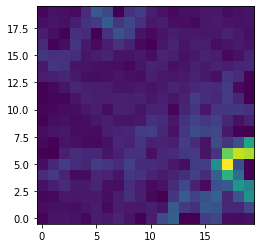

In [11]:
if __name__ == "__main__":
    logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

    graph = tf.Graph()
    with graph.as_default():
        # Make sure you allow_soft_placement, some ops have to be put on the CPU (e.g. summary operations)
        session = tf.Session(config=tf.ConfigProto(
            allow_soft_placement=True,
            log_device_placement=False))
#       ori input for tf-som
#         num_inputs = 1024
#         dims = 40
#         clusters = 2
#         # Makes toy clusters with pretty clear separation, see the sklearn site for more info
#         blob_data = make_blobs(num_inputs, dims, clusters)

# cmi?
#         df = pd.read_excel("CM1.xlsx", engine="openpyxl")
#         df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
#         blob_data=df.to_numpy()
        ori_iris = np.genfromtxt('cm1.csv', skip_header=1,delimiter=',')
        iris = np.delete(ori_iris, np.s_[-1:], axis=1)
        np.set_printoptions(suppress=True)
#         num_inputs = row of data(input), dims = 
        num_inputs = 504
        dims = 40
        clusters = 2
        
        # Scale the blob data for easier training. Also index 0 because the output is a (data, label) tuple.
        scaler = StandardScaler()
        input_data = scaler.fit_transform(iris)
        batch_size = 128

        # Build the TensorFlow dataset pipeline per the standard tutorial.
        dataset = tf.data.Dataset.from_tensor_slices(input_data.astype(np.float32))
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        iterator = dataset.make_one_shot_iterator()
        next_element = iterator.get_next()

        # This is more neurons than you need but it makes the visualization look nicer
        m = 20
        n = 20

        # Build the SOM object and place all of its ops on the graph
        som = SelfOrganizingMap(m=m, n=n, dim=dims, max_epochs=20, gpus=1, session=session, graph=graph,
                                input_tensor=next_element, batch_size=batch_size, initial_learning_rate=0.1)

        init_op = tf.global_variables_initializer()
        session.run([init_op])

        # Note that I don't pass a SummaryWriter because I don't really want to record summaries in this script
        # If you want Tensorboard support just make a new SummaryWriter and pass it to this method
        som.train(num_inputs=num_inputs)

        weights = som.output_weights
        
        umatrix, bmu_loc = get_umatrix(input_data,weights, m, n)
        fig = plt.figure()
        plt.imshow(umatrix.reshape((m, n)), origin='lower')
        plt.show(block=True)